<a href="https://colab.research.google.com/github/elibtronic/STDS_transcipt_analysis/blob/main/STDS_Transcipt_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# STDS Transcript analysis

What did we talk about on all of them episodes?

In [ ]:
print("Setting up and downloading Data")

# install spacy 3.2.0 (any other 3.X version will likely work also)
#!pip install spacy==3.2.0
!pip -q install spacy
# if doing anything with word vectors use en_core_web_md or higher as the language model
# run this cell then hit ctrl-m-. to restart the runtime then proceed
!python -m spacy download en_core_web_md
!pip -q install pyLDAvis

import nltk
import requests
import glob
import gensim
import pyLDAvis
import pyLDAvis.gensim_models
import spacy

import gensim.corpora as corpora
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from os import listdir
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from zipfile import ZipFile

%matplotlib inline

TRANSCRIPT_ZIP_URL = "https://github.com/elibtronic/STDS_transcipt_analysis/raw/refs/heads/main/transcript_text.zip"

#Bigram Parameters
BIGRAM_MIN = 5 #default is 5
BIGRAM_THRESHOLD = 10 #official docs to stay away from this on unless you know what you are doing
TRIGRAM_MIN = 5
TRIGRAM_THRESHOLD = 10

#CONSISTENT MODEL PARAMETERS

ALPHA ='auto'             #default 'symmetric'
CHUNKSIZE = 100           #default 2000
COHERENCE_METHOD = 'c_v'
ITERATIONS = 200          #default 50
NUM_TOPICS = 19            #default 100
PASSES = 10               #default 1
PER_WORD_TOPICS = False   #default False
RANDOM_STATE = 100
UPDATE_EVERY = 1          #default 1
TOPICS_TO_SHOW = 50


ALLOWED_POSTAGS = [
    "ADJ",
    "ADP",
    "ADV",
    "AUX",
    "CONJ"
    "CCONJ",
    "DET",
    "INTJ",
    "NOUN",
#    "PART",
    "PRON",
#    "PROPN",
    "SCONJ",
    "VERB"
]

#Extra Stopwords?

#Can I force academic_freedom to be a bigram?

EXTRA_STOPWORDS = [
    "Tim",
    "tim",
    "Ribaric",
    "ribaric",
    "Tim Ribaric",
    "tim ribaric",
    "Alicia",
    "alicia",
    "Floyd",
    "floyd",
    "alicia floyd",
    "Daniel",
    "daniel"
    "Brett",
    "brett",
    "Daniel Brett",
    "daniel brett",
    "Erin",
    "erin",
    "Daly",
    "Erin Daly"
    "erin daly"
    ]



requests.get(TRANSCRIPT_ZIP_URL)
with open("transcript_text.zip", "wb") as f:
    f.write(requests.get(TRANSCRIPT_ZIP_URL).content)

zipfile = ZipFile("transcript_text.zip")
zipfile.extractall()
zipfile.close()

In [2]:
#Loads and parses the transcripts
data = []
f_lookup = []

for f in sorted(listdir("transcript_text/")):
  #print(f.split("-Transcript")[0])
  f_lookup.append(f.split("-Transcript")[0])
  line = open("transcript_text/"+f, "r").readlines()
  data.append(line)


#Stop words
nltk.download('stopwords')
#Out of the can version
stop_words = stopwords.words('english')

#Add yer extras here
for word in EXTRA_STOPWORDS:
  stop_words.append(word)

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#Bigram & Trigram Creation

#bigram = gensim.models.Phrases(data_words, min_count=BIGRAM_MIN, threshold = BIGRAM_MAX)
bigram = gensim.models.Phrases(data_words, min_count=BIGRAM_MIN,threshold= BIGRAM_THRESHOLD)
trigram = gensim.models.Phrases(bigram[data_words], min_count=TRIGRAM_MIN, threshold = TRIGRAM_THRESHOLD)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#Peform text normalizaiton
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
def lemmatization(texts, allowed_postags):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out



## PROCESS TEXTS


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_bigrams)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

#data_lemmatized = lemmatization(data_words_nostops, allowed_postags=ALLOWED_POSTAGS)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=ALLOWED_POSTAGS) #Bigrams
#data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=ALLOWED_POSTAGS) #Trigrams

# BAG OF WORDS ETC


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


print("Done Prepping text!")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Done Prepping text!


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


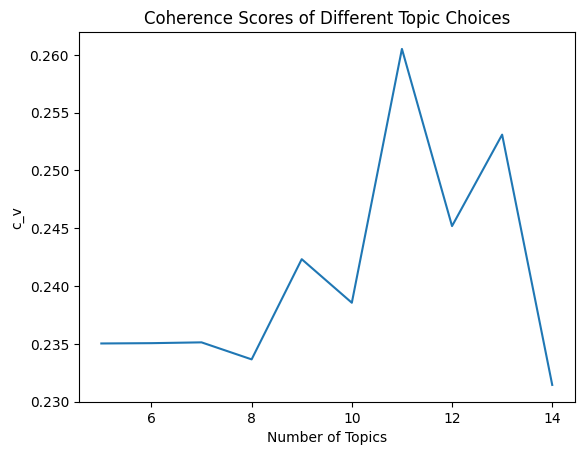

,num_topics,c_v
0,5,0.235034
1,6,0.235060
2,7,0.235130
3,8,0.233657
4,9,0.242324
5,10,0.238555
6,11,0.260510
7,12,0.245187
8,13,0.253096
9,14,0.231448


In [3]:
#Just run this cell to get a bead on the number of topics LDA should use

TOPIC_CHOICES = range(5,15)
c_Scores = []
for t_number in sorted(TOPIC_CHOICES):
    lda_model_coh = gensim.models.ldamodel.LdaModel(\
                                                alpha=ALPHA,
                                                chunksize=CHUNKSIZE,
                                                corpus=corpus,
                                                id2word=id2word,
                                                iterations = ITERATIONS,
                                                num_topics=t_number,
                                                passes= PASSES,
                                                per_word_topics= PER_WORD_TOPICS,
                                                random_state=RANDOM_STATE,
                                                update_every=UPDATE_EVERY,
                                               )

    cs = CoherenceModel(model = lda_model_coh, \
                               texts = texts, \
                               dictionary = id2word, \
                               coherence = COHERENCE_METHOD
                     )
    c_Scores.append(cs.get_coherence())


plt.plot(TOPIC_CHOICES, c_Scores)
plt.title("Coherence Scores of Different Topic Choices")
plt.ylabel(COHERENCE_METHOD)
plt.xlabel("Number of Topics")
plt.show()

cScore_df = pd.DataFrame(list(zip(TOPIC_CHOICES,c_Scores)))
cScore_df.columns = ["num_topics",COHERENCE_METHOD]
cScore_df

In [21]:
#How many topics now that we have the analysis above?
NUM_TOPICS = 11

#Generate Model and get basic dynamics of it
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,\
                                                id2word=id2word,\
                                                num_topics=NUM_TOPICS,\
                                                random_state = RANDOM_STATE,\
                                                update_every = UPDATE_EVERY,\
                                                chunksize = CHUNKSIZE,\
                                                passes = PASSES,\
                                                alpha = ALPHA,\
                                                iterations = ITERATIONS,\
                                                per_word_topics = PER_WORD_TOPICS)

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence = COHERENCE_METHOD)
print("Perplexity: ", lda_model.log_perplexity(corpus))
print("Coherence: ", coherence_model_lda.get_coherence())

pyLDAvis.enable_notebook()
#Projection parameter
# tsne
# mmds
# pcoa
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,id2word,mds="mmds")
pyLDAvis.save_html(vis, "STDS_topics.html")
vis


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  -7.264982229802327
Coherence:  0.26050963957227175


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.038870  0.116886       1        1  63.457637
0     -0.030816  0.142128       2        1  10.072112
9      0.008823  0.174347       3        1   8.666356
1      0.102629  0.143767       4        1   8.198184
7      0.149490  0.076616       5        1   5.113477
4     -0.102471  0.140929       6        1   4.181549
10     0.036754 -0.143953       7        1   0.307576
5     -0.049362 -0.160355       8        1   0.000782
2     -0.050042 -0.159563       9        1   0.000778
8     -0.051012 -0.167321      10        1   0.000777
6     -0.052864 -0.163479      11        1   0.000772, topic_info=      Term         Freq        Total Category  logprob  loglift
201     go  1851.000000  1851.000000  Default  30.0000  30.0000
271   like  1730.000000  1730.000000  Default  29.0000  29.0000
561   yeah  1308.000000  1308.000000  Default  28.0000  28.0000
504  think  1594.000000  1594.000000  Default  27.0000  27.0000
503  thing  1192.000000  1192.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
488   talk     0.000182   384.087416  Topic11  -8.3842  -2.7933
321   need     0.000179   320.601962  Topic11  -8.3988  -2.6273
540     we     0.000181   410.599724  Topic11  -8.3863  -2.8622
113    day     0.000180   382.484593  Topic11  -8.3935  -2.7985
538   want     0.000181   474.187578  Topic11  -8.3846  -3.0045

[825 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3665      4  0.983803     adulte
5392      3  0.844736  adulthood
5393      3  0.913117     adulty
5552      3  0.948936  adversity
2822      1  0.966383     advice
...     ...       ...        ...
562       4  0.044972       year
562       5  0.016353       year
562       6  0.098120       year
1853      1  0.299943   year_old
1853      4  0.699866   year_old

[1101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 10, 2, 8, 5, 11, 6, 3, 9, 7])

In [22]:
#standalone HTML
pyLDAvis.save_html(vis, "STDS_topics.html")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


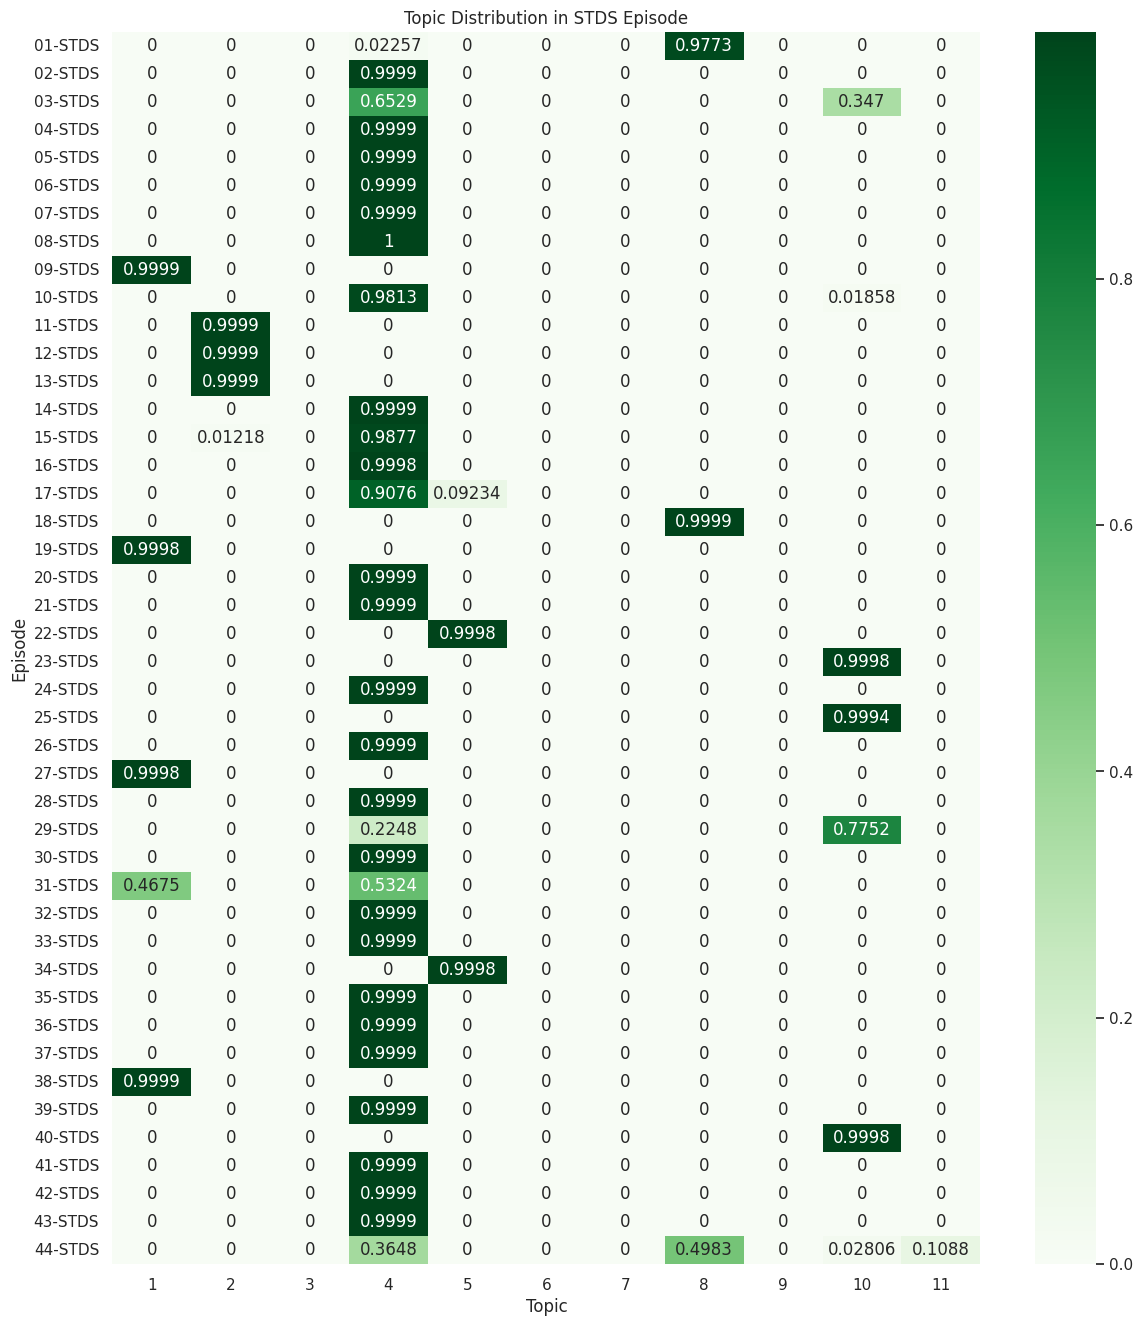

In [29]:
cat_df = pd.DataFrame(f_lookup,columns=["Episode"])

cat = []

for i in range(0,len(corpus)):
  #print(lda_model.get_document_topics(corpus[i])[0])
  t_list = []
  for topics in lda_model.get_document_topics(corpus[i]):
    t_list.append(tuple([topics[0]+1,topics[1]]))
  #print(sorted(t_list))
  #print("\n")
  cat.append(t_list)

cat_df['Topics']= cat
#cat_df

#Heatmap of topics?

total_hm = []

for i,r in cat_df.iterrows():
  #print(r["Episode"])
  top_hm = {}
  for i in range(1,NUM_TOPICS+1):
    top_hm[i] = 0
  for t in r["Topics"]:
    top_hm[t[0]] = t[1]
  line = []
  line.append(r["Episode"])
  for v in top_hm.values():
    line.append(v)
  total_hm.append(line)

hm_df = pd.DataFrame(total_hm,columns=["Episode","1","2","3","4","5","6","7","8","9","10","11"])
hm_df

del(hm_df["Episode"])


s_labels = []
ep_labels_o = list(cat_df.Episode)
for s in ep_labels_o:
  s_labels.append(s.replace("_"," "))

sns.set(rc={'figure.figsize':(14,16)})
sns.heatmap(
           hm_df,
           #square=True,
           yticklabels=s_labels,
           cmap="Greens",
           annot=True,
           fmt='.4g'
           )
plt.xlabel("Topic")
plt.ylabel("Episode")
plt.title("Topic Distribution in STDS Episode")
plt.show()

In [28]:
#Display specific Range in Topics
TSTART = 1
TEND = 10

for t in range(0,NUM_TOPICS):
  print("Topic ",t+1)
  t_list = []
  for tp in lda_model.show_topic(t,topn=TEND):
    t_list.append(tp[0])
  print(t_list[TSTART:],"\n")


Topic  1
['go', 'think', 'get', 'yeah', 'day', 'would', 'oh', 'know', 'thing'] 

Topic  2
['think', 'like', 'go', 'thing', 'know', 'say', 'get', 'job', 'yeah'] 

Topic  3
['say', 'think', 'like', 'get', 'thing', 'yeah', 'know', 'really', 'would'] 

Topic  4
['like', 'think', 'get', 'yeah', 'thing', 'say', 'know', 'would', 'people'] 

Topic  5
['go', 'think', 'like', 'get', 'tabitha_lewis', 'thing', 'people', 'right', 'okay'] 

Topic  6
['go', 'think', 'get', 'thing', 'work', 'yeah', 'would', 'oh', 'like'] 

Topic  7
['go', 'get', 'time', 'know', 'yeah', 'think', 'thing', 'people', 'something'] 

Topic  8
['like', 'think', 'question', 'tool', 'would', 'love', 'pet', 'use', 'research'] 

Topic  9
['go', 'thing', 'know', 'get', 'people', 'yeah', 'think', 'say', 'makerspace'] 

Topic  10
['go', 'thing', 'think', 'yeah', 'get', 'work', 'move', 'time', 'would'] 

Topic  11
['really', 'evan_williamson', 'metadata', 'template', 'devin_becker', 'collection', 'olivia_wikle', 'work', 'sheet'] 



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
